In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss

import os
import datetime
import itertools


def printTime(tag):
    """
    ログ出力用の関数
    """
    print(tag + ':', datetime.datetime.now())


printTime('Inputファイルを表示')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Inputファイルを表示: 2020-03-23 10:37:37.057291
/kaggle/input/data_description_ja.md
/kaggle/input/test.csv
/kaggle/input/data_description.txt
/kaggle/input/train.csv
/kaggle/input/.ipynb_checkpoints/train-checkpoint.csv
/kaggle/input/.ipynb_checkpoints/test-checkpoint.csv
/kaggle/input/.ipynb_checkpoints/data_description-checkpoint.txt


#### 学習データの読み込み

In [2]:
train = pd.read_csv('/kaggle/input/train.csv')
test = pd.read_csv('/kaggle/input/test.csv')

# 学習データを特徴量と目的変数に分ける
train_x = train.drop(['Id', 'SalePrice'], axis=1)
train_y = train['SalePrice']

# テストデータは特徴量のみなので、そのままでよい
test_x = test.drop(['Id'], axis=1)
test_id = test['Id']

 #### 特徴量作成

In [3]:
# 解析対象とする数値列を設定
targets_num = ['1stFlrSF',
               '2ndFlrSF',
               'BsmtFinSF1',
               'Fireplaces',
               'FullBath',
               'GarageArea',
               'GarageCars',
               'GarageYrBlt',
               'GrLivArea',
               'MasVnrArea',
               'OverallQual',
               'OverallCond',
               'TotalBsmtSF',
               'TotRmsAbvGrd',
               'YearBuilt',
               'YearRemodAdd']

# 解析対象とするカテゴリ列を設定
targets_category = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    # 'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'ExterQual',
    'ExterCond',
    'Foundation',
    # 'BsmtQual',
    # 'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'Heating',
    'HeatingQC',
    'CentralAir',
    'Electrical',
    # 'KitchenQual',
    'Functional',
    # 'FireplaceQu',
    'GarageType',
    'GarageFinish',
    # 'GarageQual',
    'GarageCond',
    'PavedDrive',
    # 'PoolQC',
    'Fence',
    'MiscFeature',
    'SaleType',
    'SaleCondition']

# 解析対象とする数値列とカテゴリ列の列名を連結
targets = targets_num
targets.extend(targets_category)

# Dataframeの列の型がobjectのままだとLabelEncoderでエラーするため、strに変換
# ※変換処理後にinfo()で型を確認しても、objectと表示されるが内部的にはstrに変換されている。
train_x[targets_category] = train_x[targets_category].astype(str)
test_x[targets_category] = test_x[targets_category].astype(str)

In [4]:

def addTotalGrSF(df):
    
    dv_ary = []
    for index, row in df.iterrows():

        dv_ary.append(row['1stFlrSF'] + row['2ndFlrSF'])

    # Seriesに変換
    dv = pd.Series(dv_ary).astype(float)
    # DataFrameと結合
    df['TotalGrSF'] = dv


addTotalGrSF(train_x)
addTotalGrSF(test_x)

In [5]:

def setAstype(train, test, colName, setType):

    train[colName] = train[colName].astype(setType)
    test[colName] = test[colName].astype(setType)


dec = {
    'LotShape': {
        'Reg': 4,
        'IR1': 3,
        'IR2': 2,
        'IR3': 1
    },
    'BsmtCond': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1,
        'NA': 0
    },
    'BsmtQual': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1,
        'NA': 0
    },
    'FireplaceQu': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1,
        'NA': 0
    },
    'KitchenQual': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1,
        'NA': 0
    },
    'PoolQC': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1,
        'NA': 0
    },
    'GarageQual': {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1,
        'NA': 0
    },
}

train_x.replace(dec, inplace=True)
test_x.replace(dec, inplace=True)

# 型を設定（後の計算でのエラー回避のため）
setAstype(train_x, test_x, 'LotShape', 'float')
setAstype(train_x, test_x, 'BsmtCond', 'float')
setAstype(train_x, test_x, 'BsmtQual', 'float')
setAstype(train_x, test_x, 'FireplaceQu', 'float')
setAstype(train_x, test_x, 'KitchenQual', 'float')
setAstype(train_x, test_x, 'PoolQC', 'float')
setAstype(train_x, test_x, 'GarageQual', 'float')

In [6]:

def calcFeatureValue(df, col1, calc, col2):

    dv_ary = []
    for index, row in df.iterrows():
        if calc == 'multi':

            if np.isnan(row[col1]) or np.isnan(row[col2]):
                dv_ary.append(np.log(0))
            else:
                dv_ary.append(np.log(row[col1] * row[col2]))

        elif calc == 'div':
            if np.isnan(row[col2]) or row[col2] == 0:
                dv_ary.append(0)
            else:
                dv_ary.append(row[col1] / row[col2])

        else:
            raise Exception('calcの値が不正です')

    # Seriesに変換
    dv = pd.Series(dv_ary).astype(float)
    # DataFrameと結合
    df[col1 + '_' + calc + '_' + col2] = dv


def addFeatureValue(df1, df2, col1, calc, col2):

    calcFeatureValue(df1, col1, calc, col2)
    calcFeatureValue(df2, col1, calc, col2)


addFeatureValue(train_x, test_x, 'LotArea', 'multi', 'LotShape')
addFeatureValue(train_x, test_x, 'LotArea', 'div', 'LotShape')
addFeatureValue(train_x, test_x, 'LotShape', 'div', 'LotArea')

addFeatureValue(train_x, test_x, 'TotalBsmtSF', 'multi', 'BsmtCond')
addFeatureValue(train_x, test_x, 'TotalBsmtSF', 'div', 'BsmtCond')
addFeatureValue(train_x, test_x, 'BsmtCond', 'div', 'TotalBsmtSF')

addFeatureValue(train_x, test_x, 'BsmtQual', 'multi', 'BsmtCond')
addFeatureValue(train_x, test_x, 'BsmtQual', 'div', 'BsmtCond')
addFeatureValue(train_x, test_x, 'BsmtCond', 'div', 'BsmtQual')

addFeatureValue(train_x, test_x, 'GrLivArea', 'multi', 'TotalGrSF')
addFeatureValue(train_x, test_x, 'GrLivArea', 'div', 'TotalGrSF')
addFeatureValue(train_x, test_x, 'TotalGrSF', 'div', 'GrLivArea')

addFeatureValue(train_x, test_x, 'GrLivArea', 'multi', '1stFlrSF')
addFeatureValue(train_x, test_x, 'GrLivArea', 'div', '1stFlrSF')
addFeatureValue(train_x, test_x, '1stFlrSF', 'div', 'GrLivArea')

addFeatureValue(train_x, test_x, 'GrLivArea', 'multi', '2ndFlrSF')
addFeatureValue(train_x, test_x, 'GrLivArea', 'div', '2ndFlrSF')
addFeatureValue(train_x, test_x, '2ndFlrSF', 'div', 'GrLivArea')

addFeatureValue(train_x, test_x, 'Fireplaces', 'multi', 'FireplaceQu')
addFeatureValue(train_x, test_x, 'Fireplaces', 'div', 'FireplaceQu')
addFeatureValue(train_x, test_x, 'FireplaceQu', 'div', 'Fireplaces')

addFeatureValue(train_x, test_x, 'KitchenAbvGr', 'multi', 'KitchenQual')
addFeatureValue(train_x, test_x, 'KitchenAbvGr', 'div', 'KitchenQual')
addFeatureValue(train_x, test_x, 'KitchenQual', 'div', 'KitchenAbvGr')

addFeatureValue(train_x, test_x, 'BedroomAbvGr', 'multi', 'TotRmsAbvGrd')
addFeatureValue(train_x, test_x, 'BedroomAbvGr', 'div', 'TotRmsAbvGrd')
addFeatureValue(train_x, test_x, 'TotRmsAbvGrd', 'div', 'BedroomAbvGr')

addFeatureValue(train_x, test_x, 'PoolQC', 'multi', 'PoolArea')
addFeatureValue(train_x, test_x, 'PoolQC', 'div', 'PoolArea')
addFeatureValue(train_x, test_x, 'PoolArea', 'div', 'PoolQC')

addFeatureValue(train_x, test_x, 'GarageQual', 'multi', 'GarageArea')
addFeatureValue(train_x, test_x, 'GarageQual', 'div', 'GarageArea')
addFeatureValue(train_x, test_x, 'GarageArea', 'div', 'GarageQual')

addFeatureValue(train_x, test_x, 'GarageCars', 'multi', 'GarageArea')
addFeatureValue(train_x, test_x, 'GarageCars', 'div', 'GarageArea')
addFeatureValue(train_x, test_x, 'GarageArea', 'div', 'GarageCars')

addFeatureValue(train_x, test_x, 'OverallQual', 'multi', 'YearBuilt')
addFeatureValue(train_x, test_x, 'OverallQual', 'div', 'YearBuilt')
addFeatureValue(train_x, test_x, 'YearBuilt', 'div', 'OverallQual')

addFeatureValue(train_x, test_x, 'OverallQual', 'multi', 'YearRemodAdd')
addFeatureValue(train_x, test_x, 'OverallQual', 'div', 'YearRemodAdd')
addFeatureValue(train_x, test_x, 'YearRemodAdd', 'div', 'OverallQual')

addFeatureValue(train_x, test_x, 'BsmtUnfSF', 'multi', 'TotalBsmtSF')
addFeatureValue(train_x, test_x, 'BsmtUnfSF', 'div', 'TotalBsmtSF')
addFeatureValue(train_x, test_x, 'TotalBsmtSF', 'div', 'BsmtUnfSF')

addFeatureValue(train_x, test_x, 'FullBath', 'multi', 'TotalGrSF')
addFeatureValue(train_x, test_x, 'FullBath', 'div', 'TotalGrSF')
addFeatureValue(train_x, test_x, 'TotalGrSF', 'div', 'FullBath')

addFeatureValue(train_x, test_x, 'HalfBath', 'multi', 'TotalGrSF')
addFeatureValue(train_x, test_x, 'HalfBath', 'div', 'TotalGrSF')
addFeatureValue(train_x, test_x, 'TotalGrSF', 'div', 'HalfBath')

addFeatureValue(train_x, test_x, 'BedroomAbvGr', 'multi', 'TotalGrSF')
addFeatureValue(train_x, test_x, 'BedroomAbvGr', 'div', 'TotalGrSF')
addFeatureValue(train_x, test_x, 'TotalGrSF', 'div', 'BedroomAbvGr')

addFeatureValue(train_x, test_x, '1stFlrSF', 'multi', 'OverallQual')
addFeatureValue(train_x, test_x, '1stFlrSF', 'multi', 'YearBuilt')
addFeatureValue(train_x, test_x, '1stFlrSF', 'multi', 'YearRemodAdd')
addFeatureValue(train_x, test_x, '1stFlrSF', 'multi', 'FullBath')

addFeatureValue(train_x, test_x, 'GrLivArea', 'multi', 'OverallQual')
addFeatureValue(train_x, test_x, 'GrLivArea', 'multi', 'YearBuilt')
addFeatureValue(train_x, test_x, 'GrLivArea', 'multi', 'YearRemodAdd')
addFeatureValue(train_x, test_x, 'GrLivArea', 'multi', 'FullBath')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [7]:

def addBlnReform(df):
    """
    特徴量を追加する関数
    """
    dv_ary = []
    for index, row in df.iterrows():

        if row['YearBuilt'] == row['YearRemodAdd']:
            dv_ary.append(0)
        else:
            dv_ary.append(1)

    # Seriesに変換
    dv = pd.Series(dv_ary).astype(int)
    # DataFrameと結合
    df['isReform'] = dv

# addBlnReform(train_x)
# addBlnReform(test_x)

In [8]:

# ラベルエンコーディング用に学習データとテストデータをunion
lavel_x = train_x.append(test_x, ignore_index=True)

# カテゴリ変数をlabel encodingする
for c in targets_category:
    # 学習データとテストデータに基づいてラベルを設定
    le = LabelEncoder()
    le.fit(lavel_x[c])
    train_x[c] = le.transform(train_x[c])
    test_x[c] = le.transform(test_x[c])

#### モデル作成とバリデーション
LightGBMを使用してモデルを作成します。

モデルの作成開始: 2020-03-23 10:38:01.663942
[5]	train's l2: 4.48622e+09	valid's l2: 3.90932e+09
[10]	train's l2: 3.13333e+09	valid's l2: 2.70755e+09
[15]	train's l2: 2.27236e+09	valid's l2: 1.96453e+09
[20]	train's l2: 1.74754e+09	valid's l2: 1.536e+09
[25]	train's l2: 1.37008e+09	valid's l2: 1.24049e+09


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Alley', 'BldgType', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'LandContour', 'LandSlope', 'LotConfig', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[30]	train's l2: 1.10647e+09	valid's l2: 1.04539e+09
[35]	train's l2: 8.98337e+08	valid's l2: 9.06474e+08
[40]	train's l2: 7.54309e+08	valid's l2: 8.52794e+08
[45]	train's l2: 6.62921e+08	valid's l2: 7.95947e+08
[50]	train's l2: 5.84733e+08	valid's l2: 7.66306e+08
[55]	train's l2: 5.33065e+08	valid's l2: 7.46905e+08
[60]	train's l2: 4.91778e+08	valid's l2: 7.29717e+08
[65]	train's l2: 4.55655e+08	valid's l2: 7.29012e+08
[70]	train's l2: 4.25594e+08	valid's l2: 7.33111e+08
[75]	train's l2: 3.98307e+08	valid's l2: 7.21676e+08
[80]	train's l2: 3.75616e+08	valid's l2: 7.2845e+08
[85]	train's l2: 3.5739e+08	valid's l2: 7.35097e+08
[90]	train's l2: 3.43256e+08	valid's l2: 7.45117e+08
[95]	train's l2: 3.29117e+08	valid's l2: 7.54222e+08
[100]	train's l2: 3.15753e+08	valid's l2: 7.56247e+08
RMSE: 0.1417
モデルの作成終了: 2020-03-23 10:38:03.023450


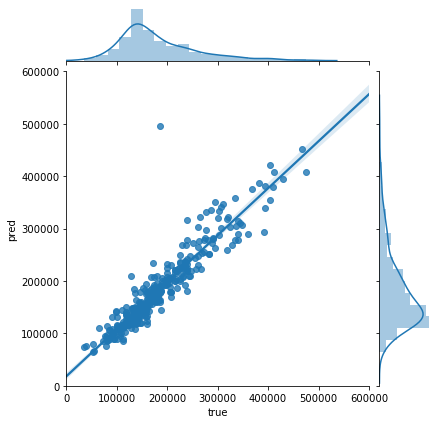

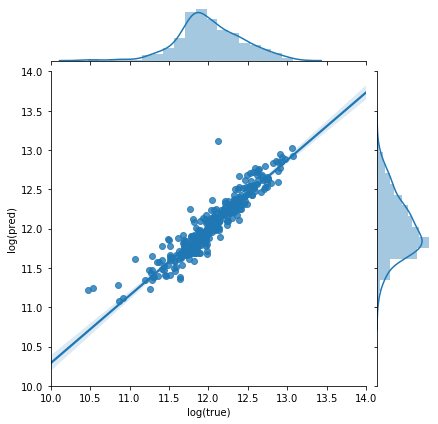

In [9]:
printTime('モデルの作成開始')

# 学習データを学習データとバリデーションデータに分ける
kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

# 特徴量と目的変数をlightgbmのデータ構造に変換する
lgb_train = lgb.Dataset(tr_x, tr_y)
lgb_eval = lgb.Dataset(va_x, va_y)

# ハイパーパラメータの設定
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'l2',
    'num_leaves': 40,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l2': 2,
}

# 作成する決定木の数を指定
num_round = 100

# 学習の実行
# カテゴリ変数をパラメータで指定している
# バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
model = lgb.train(params,
                  lgb_train,
                  num_boost_round=num_round,
                  categorical_feature=targets_category,
                  valid_names=['train', 'valid'],
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=5)

# バリデーションデータでのスコアの確認
va_pred = model.predict(va_x)

# バリデーションデータでのスコア(真の値の対数と予測値の対数の二乗平均平方根誤差 (RMSE))を計算する
rmse = np.sqrt(mean_squared_error(np.log(va_y), np.log(va_pred)))

print(f'RMSE: {rmse:.4f}')

# 結果の可視化
sns.jointplot(
    va_y,
    va_pred,
    kind="reg",
    xlim=(0, 600000),
    ylim=(0, 600000)
).set_axis_labels("true", "pred")

sns.jointplot(
    np.log(va_y),
    np.log(va_pred),
    kind="reg",
    xlim=(10, 14),
    ylim=(10, 14)
).set_axis_labels("log(true)", "log(pred)")

# 予測
pred = model.predict(test_x)

# 提出用ファイルの作成
submission = pd.DataFrame({'Id': test_id, 'SalePrice': pred})
submission.to_csv('/kaggle/output/submission_first.csv', index=False)

printTime('モデルの作成終了')

#### データの分析にどの特徴量が重要だったのかをプロット

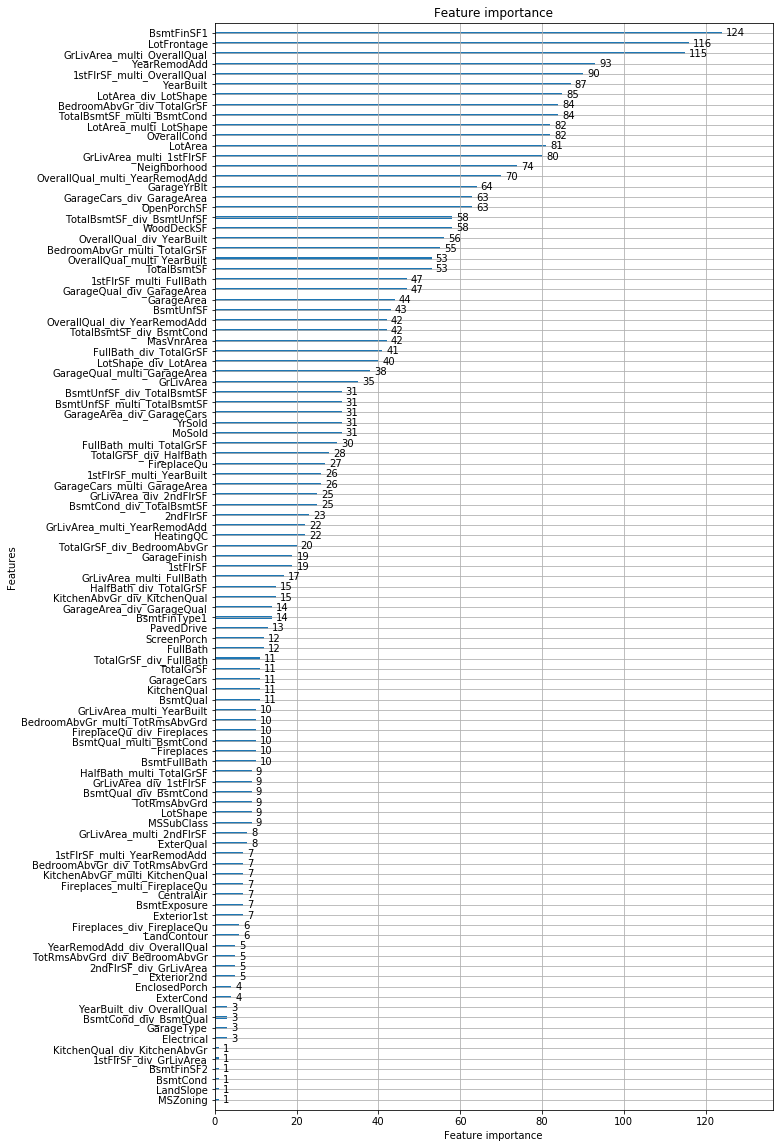

In [10]:
lgb.plot_importance(model, figsize=(10, 20))

#### 分析に使用した決定木を可視化

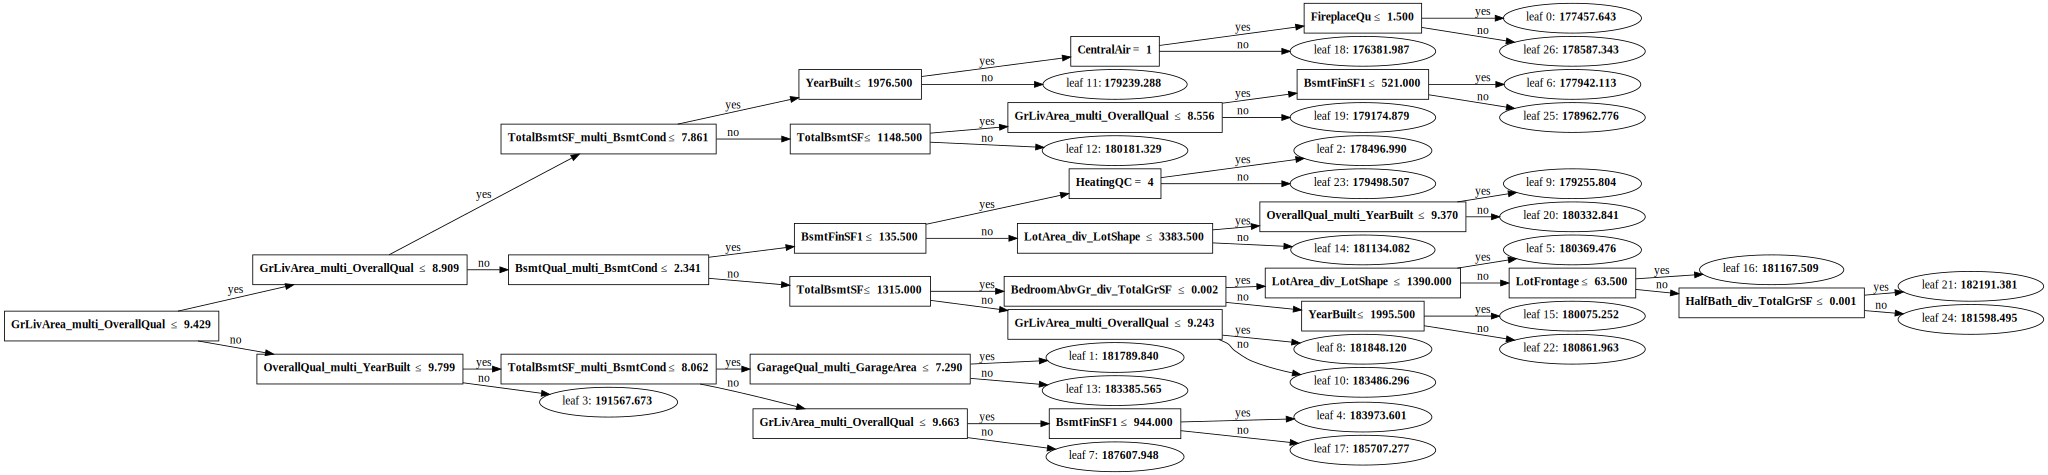

In [11]:
lgb.create_tree_digraph(model)